In [20]:
%reload_ext autoreload
%autoreload 2

# %matplotlib qt

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import sklearn
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [12]:
@torch.no_grad()
def cvPCA(X1, X2):
    """X1, X2 are both (dimensions x samples)"""
    D, B = X1.shape
    assert X2.shape == (D, B), "shape of X1 and X2 is not the same"
    _, u = utils.smart_pca(X1)
    
    cproj0 = X1.T @ u
    cproj1 = X2.T @ u
    ss = (cproj0 * cproj1).mean(axis=0)
    return ss

def get_num_components(nc, shape):
    return nc if nc is not None else min(shape)

@torch.no_grad()
def shuff_cvPCA(X1, X2, nshuff=5, cvmethod=cvPCA):
    """X1, X2 are both (dimensions x samples)"""
    D, B = X1.shape
    assert X2.shape == (D, B), "shape of X1 and X2 is not the same"
    nc = get_num_components(None, (D, B))
    ss=torch.zeros((nshuff,nc))
    X = torch.stack((X1, X2))
    for k in range(nshuff):
        iflip = 1*(torch.rand(B) > 0.5)
        X1c = torch.gather(X, 0, iflip.view(1, 1, -1).expand(1, D, -1)).squeeze(0)
        X2c = torch.gather(X, 0, -(iflip-1).view(1, 1, -1).expand(1, D, -1)).squeeze(0)
        ss[k]=cvmethod(X1c, X2c)
    return ss

In [13]:
model_name = 'MLP'
dataset_name = 'MNIST'

# hidden_widths = [400, 400, 400]
net = get_model(model_name, build=True, dataset=dataset_name, dropout=0.0, ignore_flag=False)
net.to(DEVICE)

loader_parameters = dict(
    shuffle=True,
)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, loader_parameters=loader_parameters, device=DEVICE)

optimizer = torch.optim.Adam(net.parameters())

parameters = dict(
    num_epochs=20,
    alignment=False,
    compare_expected=False,
    frequency=5,
    delta_alignment=False,
)
results = train.train([net], [optimizer], dataset, **parameters)

training epoch: 100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


In [49]:
images = []
labels = []
for batch in tqdm(dataset.train_loader):
    cimages, clabels = dataset.unwrap_batch(batch)
    images.append(cimages)
    labels.append(clabels)
images = torch.concatenate(images, dim=0)
images = images.view(images.size(0), -1)
# images = images - images.mean(dim=0)
labels = torch.concatenate(labels, dim=0)
print(images.shape, labels.shape)

# get stacked indices to the elements of each class
classes = torch.unique(labels)
num_classes = len(classes)
idx_to_class = [torch.where(labels == ii)[0] for ii in classes]
num_per_class = [len(idx) for idx in idx_to_class]
min_per_class = min(num_per_class)
if any([npc > min_per_class for npc in num_per_class]):
    idx_to_class = [idx[:min_per_class] for idx in idx_to_class]

# use single tensor for fast indexing
idx_to_class = torch.stack(idx_to_class).unsqueeze(2)

# (classes, images, image_dimension)
images_by_class = torch.gather(images.unsqueeze(0).expand(num_classes, -1, -1), 1, idx_to_class.expand(-1, -1, images.size(1)))

100%|██████████| 59/59 [00:05<00:00, 11.52it/s]

torch.Size([60000, 784]) torch.Size([60000])


In [50]:
# Make a CV Dataset of inputs to each layer for each class
inputs_to_layers = net.get_layer_inputs(images, precomputed=False)
inputs_by_class = [torch.gather(inputs.unsqueeze(0).expand(num_classes, -1, -1), 1, idx_to_class.expand(-1, -1, inputs.size(1))) 
                   for inputs in inputs_to_layers]

print([i.shape for i in inputs_to_layers])
print([i.shape for i in inputs_by_class])
print(images_by_class.shape)

[torch.Size([60000, 784]), torch.Size([60000, 100]), torch.Size([60000, 100]), torch.Size([60000, 50])]
[torch.Size([10, 5421, 784]), torch.Size([10, 5421, 100]), torch.Size([10, 5421, 100]), torch.Size([10, 5421, 50])]
torch.Size([10, 5421, 784])


In [51]:
# make a CV dataset
num_per_class = images_by_class.size(1)
random_sort = torch.randperm(num_per_class)
train_examples = random_sort[:num_per_class//2]
test_examples = random_sort[num_per_class//2:num_per_class//2+num_per_class//2]
inputs_train = [inputs[:, train_examples].reshape(-1, inputs.size(2)) for inputs in inputs_by_class]
inputs_test = [inputs[:, test_examples].reshape(-1, inputs.size(2)) for inputs in inputs_by_class]

# measure eigenfeatures
w, v = utils.named_transpose([utils.smart_pca(inputs.T) for inputs in inputs_to_layers])
w = [(w / torch.sum(w)).cpu() for w in w]

# cvPCA method
cc = [utils.shuff_cvPCA(itrain.T.cpu(), itest.T.cpu(), nshuff=5).cpu() for itrain, itest in zip(inputs_train, inputs_test)]
cc = [cc.mean(dim=0) for cc in cc]
cc = [cc / torch.sum(cc) for cc in cc]

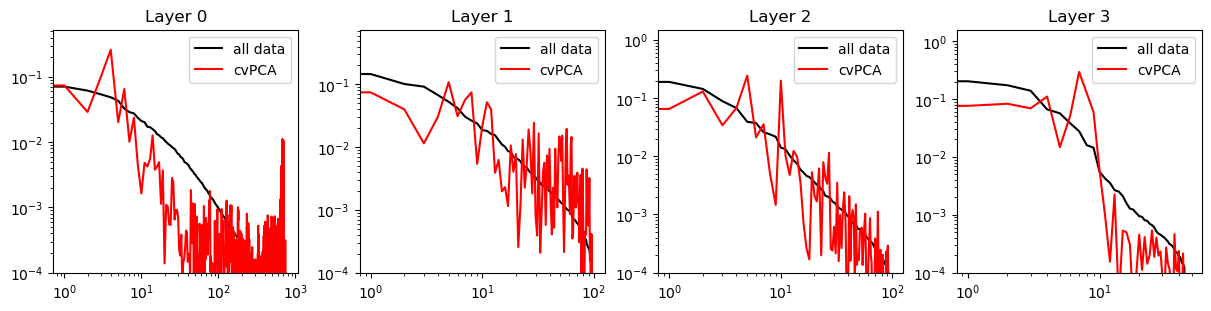

In [52]:
cumsum = True

num_layers = len(w)
figdim = 3
fig, ax = plt.subplots(1, num_layers, figsize=(num_layers*figdim, figdim), layout='constrained')
for layer in range(num_layers):
    ax[layer].plot(range(len(w[layer])), w[layer], c='k', label='all data')
    ax[layer].plot(range(len(w[layer])), cc[layer], c='r', label='cvPCA')
    ax[layer].set_xscale('log')
    ax[layer].set_yscale('log')
    ax[layer].set_title(f"Layer {layer}")
    ax[layer].legend()
    ax[layer].set_ylim(1e-4)
plt.show()

# plt.plot(range(784), torch.cumsum(w, 0), c='k', label='all data')
# plt.plot(range(784), torch.cumsum(cc, 0), c='r', label='cvPCA')
# plt.xscale('log')
# # plt.yscale('log')
# # plt.ylim(1e-5)
# plt.legend()
# plt.show()


# I'd like to compare these cvPCA results to the observed alignment distribution
# to determine if the reason alignment and delta alignment is much higher than expected
# according to Ila Fiete is because of the batching implicitly "cross-validating" the 
# updates according to class-dependent structure rather than simply all structure. 

# In other words, if it is the case that the network primarily learns stimulus specific
# dimensions, rather than full data dimensions, it may be because any other dimensions
# are ignored by the batching. (And therefore implicitly prevents over-generalization!)

# Other experiment: Determine if these dimensions are overrepresented in the dataset. 